In [1]:
import os
import time
import torch
import pandas as pd
import torch.nn as nn
import torch.nn.init as init
import torch.optim as optim
import torchvision.transforms as T
import numpy as np
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torchtext

from copy import deepcopy
from IPython.display import display
from collections import defaultdict
from torchvision import datasets
from torch.distributions.categorical import Categorical
from torch.distributions.bernoulli import Bernoulli 
from torch.utils.data import DataLoader
from IPython.display import clear_output

%matplotlib inline
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

'''
TODO:

1. Bidirectional SE and TE
2. Give diffrent dags for the inverse RNN
3. multiple layers Encoder
4. masking for parallize training
'''


'\nTODO:\n\n1. Bidirectional SE and TE\n2. Give diffrent dags for the inverse RNN\n3. multiple layers Encoder\n4. masking for parallize training\n'

In [2]:
class ScaledDotProductAttention(nn.Module):
    ''' Scaled Dot-Product Attention '''

    def __init__(self, temperature, i, attn_dropout=0.1):
        super().__init__()
        self.i = i
        self.temperature = temperature
        self.dropout = nn.Dropout(attn_dropout)
        self.softmax = nn.Softmax(dim=2)

    def forward(self, q, k, v, mask=None):
        
        attn = torch.bmm(q, k.transpose(1, 2)) # B, q_l, k_l
    
        attn = attn / self.temperature

        if mask is not None:
            attn = attn.masked_fill(mask, -np.inf) # and after the softmax layer, the attn will be 0

        if args.attn_softmax[self.i]:
            attn = self.softmax(attn)
        attn = self.dropout(attn)
        output = torch.bmm(attn ,v)

        return output, attn

class MultiHeadAttention(nn.Module):
    ''' Multi-Head Attention module '''

    def __init__(self, n_head, d_model, d_q, d_k, i, dropout=0.1):
        super().__init__()
        
        '''
        n_head: repeat multiple times
        '''

        self.n_head = n_head
        self.d_q = d_q
        self.d_k = d_k

        self.w_qs = nn.Linear(d_model, n_head * d_q)
        self.w_ks = nn.Linear(d_model, n_head * d_k) # dk = dv != dq
        self.w_vs = nn.Linear(d_model, n_head * d_k)
        
        nn.init.normal_(self.w_qs.weight, mean=0, std=np.sqrt(2.0 / (d_model + d_q)))
        nn.init.normal_(self.w_ks.weight, mean=0, std=np.sqrt(2.0 / (d_model + d_k)))
        nn.init.normal_(self.w_vs.weight, mean=0, std=np.sqrt(2.0 / (d_model + d_k)))

        self.attention = ScaledDotProductAttention(temperature=np.power(d_k, 0.5), i = i)
        self.layer_norm = nn.LayerNorm(d_model)

        self.fc = nn.Linear(n_head * d_k, d_model)
        nn.init.xavier_normal_(self.fc.weight)

        self.dropout = nn.Dropout(dropout)


    def forward(self, q, k, v, mask=None):

        d_q, d_k, n_head = self.d_q, self.d_k, self.n_head

        sz_b, len_q, _ = q.size() # sz_b = batch_size, and the _ = d_model?
        sz_b, len_k, _ = k.size()
        sz_b, len_v, _ = v.size()

        residual = q

        q = self.w_qs(q).view(sz_b, len_q, n_head, self.d_q)
        k = self.w_ks(k).view(sz_b, len_k, n_head, self.d_k)
        v = self.w_vs(v).view(sz_b, len_v, n_head, self.d_k)

        q = q.permute(2, 0, 1, 3).contiguous().view(-1, len_q, self.d_q) # (n*b) x lq x dk
        k = k.permute(2, 0, 1, 3).contiguous().view(-1, len_k, self.d_k) # (n*b) x lk x dk
        v = v.permute(2, 0, 1, 3).contiguous().view(-1, len_v, self.d_k) # (n*b) x lv x dv

        # lk should be the same as lv
        # Question: lq = lk = lv ? 
        
        if mask is not None:
            mask = mask.repeat(n_head, 1, 1) # (n*b) x .. x .. , what if the mask = None
            
        output, attn = self.attention(q, k, v, mask=mask)

        output = output.view(n_head, sz_b, len_q, self.d_k) # the output dim should be the same as v
        
        # d_k = d_v = d_model/ n_head = 64 
        # so n*d_v = d_model? trnasfer the dim back to d_model?
        output = output.permute(1, 2, 0, 3).contiguous().view(sz_b, len_q, -1) # b x lq x (n*dk)
        
        output = self.dropout(self.fc(output))
        output = self.layer_norm(output + residual) 

        return output, attn

class GatedLinearUnit2D(nn.Module):
    def __init__(self, i):
        '''
        for 2D
        '''
        super().__init__()
        
        self.st_conv = nn.Conv1d(args.model_dim[i], args.gated_dim[i],1,1,0)
        
        self.end_conv = nn.Conv1d(args.gated_dim[i] // 2, args.model_dim[i],1,1,0)
        
    def forward(self, x):

        x = self.st_conv(x)

        a, b = x.split(x.size(1)//2, dim=1)
        x = torch.tanh(a) * torch.sigmoid(b)
        x = self.end_conv(x)
        return x
    
class GatedLinearUnit1D(nn.Module):
    def __init__(self, i):
        '''
        for 1D
        '''
        super().__init__()
        
        self.st_Linear = nn.Linear(args.model_dim[i], args.gated_dim[i])
        
        self.end_Linear = nn.Linear(args.gated_dim[i] // 2, args.model_dim[i])
        
    def forward(self, x):

        x = self.st_Linear(x)

        a, b = x.split(x.size(2)//2, dim=2)
        x = torch.tanh(a) * torch.sigmoid(b)
        x = self.end_Linear(x)
        return x
    
class DilationConv1d(nn.Conv1d):
    def __init__(self, kernel_size = 3, dilation = 1 , i = None):
        padding = (kernel_size - 1) // 2 * dilation
        super().__init__(args.model_dim[i], args.model_dim[i], kernel_size,
                         padding = padding, dilation = dilation)
        
    def forward(self,x):
        return super().forward(x)
    
    
def cal_loss(pred, gold, smoothing):
    
    ''' Calculate cross entropy loss, apply label smoothing if needed. '''

    if smoothing:
        eps = 0.1
        n_class = pred.size(1)
        one_hot = torch.zeros_like(pred).scatter(1, gold.view(-1, 1), 1)
        one_hot = one_hot * (1 - eps) + (1 - one_hot) * eps / (n_class - 1)
        log_prb = F.log_softmax(pred, dim=1)

        non_pad_mask = gold.ne(Constants.PAD)
        loss = -(one_hot * log_prb).sum(dim=1)
        loss = loss.masked_select(non_pad_mask).sum()  # average later
    else:
        loss = F.cross_entropy(pred, gold, ignore_index=Constants.PAD, reduction='sum')

    return loss

def compute_gae(rewards, values, gamma=0.99, tau=0.95):
    '''
    Also use GAE in PPO.
    '''
    rewards = [0] * (values.size(0)-1) + [rewards]
    
    values = torch.cat([values,torch.tensor([[0.]]).to(device)],0)
    gae = 0
    returns = []
    for step in reversed(range(len(rewards))):
        delta = rewards[step] + gamma * values[step + 1]  - values[step] # Remove the gamma in here?
        gae = delta + gamma * tau * gae # -value[step] will be used in the GAE step
        returns.insert(0, gae + values[step]) # put the new one at the first, cuz we are calculating the A_GAE inversely.
    return torch.stack(returns,0) # cuz we need the gradient of value, so we have to + value[step]




def dags_translate(dags_four):

    dags_ = deepcopy(dags_four)
    
    Act_fn_dict = {
        
        0: 'Sigmoid',
        1: 'Tanh',
        2: 'Softmax',
        3: 'ReLU',
        4: 'LeakyReLU',
        5: 'Softplus'    
    }

    for dags in dags_:

        for dag in dags:

            if dag['Act_fn'] is not None:
                
                dag['Act_fn'] = Act_fn_dict[dag['Act_fn']] 
            
            if dag['Put'] == 0:
                dag['Put'] = 'Plus'
            elif dag['Put'] == 1:
                dag['Put'] = 'Emlement_Wise*'
            elif dag['Put'] == 2:
                dag['Put'] = 'Inplace'

            dag['Output'] = bool(dag['Output'])
            
    return dags_



In [3]:
class args(object):
    
    
    # Order SourceEncoder, TargetEncoder, 
    
    # SourceEncoder
    
    model_dim = [512] * 4
    attn_softmax = [True] * 4
    head = [5] * 4 
    
    attn = [5] * 4
    attn_dim = [64] * 4
    drop_r = [0.1] * 4
    bns = [5] * 4
    opts = [5] * 4
    opts_types = [2,2,4,4]
    early_output = [True] * 4
    act_fns = [6] * 4
    put = [3] * 4
    
    
    
    num_hidden_cells = [5, 5] # use decoder to output the softmax for generating the next result
    num_input_cells = [5, 5] # if the input is just a single tensor then repeat, if the input is a list then use the list
    # send hidden cells to the next, the input cells will be leaf at that time step
    
    gated_dim = model_dim
    
    C_opts = [ o*t for o, t in zip(opts, opts_types)]
    
    RNN_emb_dim = [256] * 4 
    
    # None has to be added to the list
    

    
    num_outputs = []
    
    for i in range(2):
        num_outputs.append([num_hidden_cells[i] + num_input_cells[i]]*4 + [C_opts[i] + 1] *4 + \
                           [attn[i]+1] + [(bns[i]*2)+1] + [act_fns[i] + 1] + [num_hidden_cells[i]+num_input_cells[i]] + \
                           [put[i]] + [2]
                          )

    num_outputs.append([num_hidden_cells[1]] + [num_hidden_cells[0]]*2 + [C_opts[2] + 1] * 4 + \
                       [attn[2]] + [(bns[i]*3)+1] + [act_fns[2]+1] + [num_hidden_cells[1]] + \
                       [put[2]] + [2]
                       ) 
    
    num_outputs.append([num_hidden_cells[1]]*4 + [C_opts[3] + 1] *4 + \
                       [attn[3]+1] + [(bns[i]*3)+1] + [act_fns[3]+1] + [num_hidden_cells[1]] + \
                       [put[2]] + [2] + [opts[3]]
                       )
    
    
    
    
#     step_names = ['Retrieve_cell','Retrieve_cell_1','Retrieve_cell_2','Retrieve_cell_3',
#              'Operation', 'Operation_1', 'Operation_2', 'Operation_3',
#              'Attn', 'Norm', 'Act_fn', 'Return_cell', 'Put', 'Output', 'Out_opt']
    
    step_names = [['Retrieve_cell','Retrieve_cell_1','Retrieve_cell_2','Retrieve_cell_3',
                 'Operation', 'Operation_1', 'Operation_2', 'Operation_3',
                 'Attn', 'Norm', 'Act_fn', 'Return_cell', 'Put', 'Output'],
                  ['Retrieve_cell','Retrieve_cell_1','Retrieve_cell_2','Retrieve_cell_3',
                 'Operation', 'Operation_1', 'Operation_2', 'Operation_3',
                 'Attn', 'Norm', 'Act_fn', 'Return_cell', 'Put', 'Output'],
                  ['Retrieve_cell_1','Retrieve_cell_2','Retrieve_cell_3',
                 'Operation', 'Operation_1', 'Operation_2', 'Operation_3',
                 'Attn', 'Norm', 'Act_fn', 'Return_cell', 'Put', 'Output'],
                 ['Retrieve_cell','Retrieve_cell_1','Retrieve_cell_2','Retrieve_cell_3',
                 'Operation', 'Operation_1', 'Operation_2', 'Operation_3',
                 'Attn', 'Norm', 'Act_fn', 'Return_cell', 'Put', 'Output', 'Out_opt']
                 ]
    
    none_opt_names = ['Operation','Attn','Norm','Act_fn'] # we must have out_opt to project the tensor to T_vocab_size
    
    RNN = ['LSTM']*4
    
    assert RNN[0] == RNN[1], 'SE RNN has to be the same as TE RNN'
    
    
    
    num_steps = [ len(names) for names in  step_names]
    
    names = ['SourceEncoder','TargetEncoder','ThinkingCell','Decoder']
    
    
    ### Data 
    
    batch_size = 5
    
    
    root = '../Data/multi30k/data/'

    # torchtext.datasets.Multi30k.download(root)

    DE = torchtext.data.Field(include_lengths=True,
               init_token='<sos>', eos_token='<eos>')
    EN = torchtext.data.Field(include_lengths=True,
               init_token='<sos>', eos_token='<eos>')
    
    # train, val, test = torchtext.datasets.Multi30k.splits(exts=('.de', '.en'), fields=(DE, EN), root = '../Data/multi30k/data')

    train, val, test = torchtext.datasets.TranslationDataset.splits(      
          path = root,  
          exts = ['.de', '.en'],   
          fields = [('src', DE), ('trg', EN)],
          train = 'train', 
          validation = 'val', 
          test = 'test2016')
    DE.build_vocab(train.src, min_freq=2)
    EN.build_vocab(train.trg, max_size=10000)
    train_iter, val_iter, test_iter = torchtext.data.BucketIterator.splits(
            (train, val, test), batch_size=batch_size, repeat=False)

    max_shape1 = 0 
    for iterator in [train_iter, val_iter]:
        for i in iterator:
            for inst in [i.trg, i.src]:
                if inst[0].shape[0] > max_shape1:   
                    max_shape1 = inst[0].shape[0]

    
    S_vocab_size = len(DE.vocab)
    T_vocab_size = len(EN.vocab)
    
#     # Controller
    
    
    num_layers = [5,5]
    
    label_smooth = True
    
    emb_dim = model_dim[0]
    RNN_dim = [256] * 4
    RNN_dropout = [0.1] * 4
    
    log_softmax = [False] * 4 
    
    
    shared_lr = 0.0002
    controller_lr = 0.0002
    
    eps = 1e-8
    discount = 0.9
    decay = 0.95
    epoch = 150

    shared_maxsteps = 5 # 400
    controller_maxsteps = 5 # 2000
    
    controller_sch = False
    controller_sch_steps = 2000
    controller_sch_gamma = 0.75

    shared_sch = False
    shared_sch_steps = 2000
    shared_sch_gamma = 0.75
    
    shared_grad_norm = 0.25
    controller_grad_norm = 0.25
    
    controller_L2 = 0
    shared_L2 = 1e-7

    reward_c = 80
    
    agent = 'ActorCritic' # [ActorCritic, PolicyGradient]
    
    baseline_decay = 0.95
    val_test_steps = 5
    
    critic_coef = 0.5
    entropy_coef = 0
    
    model_name = 'FetchingNAS' 
    model_path ='./'+ model_name +'/Model/'



class Constants():
    
    PAD = 1
    UNK = 0
    SOS = 2
    EOS = 3

    PAD_WORD = '<blank>'
    UNK_WORD = '<UNK>'
    SOS_WORD = '<SOS>'
    EOS_WORD = '<EOS>'

/Users/richard/.virtualenvs/python3.6/lib/python3.6/site-packages/torchtext/data/field.py:321: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(arr, volatile=not train), lengths


In [4]:
class EncodingCell(nn.Module):
    
    def __init__(self, i):
        
        super().__init__()
        '''
        This should be a RNN with Customize RNN Cells
        
        So In Every Step, the cell will recerive a hidden state and an input.
        
        it's a 2D input, so the Self-Attn can't be used.
        
        function can be used :
        
        The Bmm can't be used, but it need an activation followed by or before the bmm.
        
        no bmm since we only have two dims, but the elementwise should be allowed
        
        Linear
        
        element-wise, bmm will be included
        
        Activation Function:
        
        Softmax, ReLU, Tanh, Sigmoid, LeakyReLU, 
        
        '''
        
        self.i = i

        self.attns = nn.ModuleList()
        self.attns.extend([MultiHeadAttention(args.head[i], args.model_dim[i], args.attn_dim[i], args.attn_dim[i], i, args.drop_r[i]) for _ in range(args.attn[i])])
        
        if args.bns[i] > 0:
            self.norms = nn.ModuleList()
            self.norms.append(nn.BatchNorm1d(args.model_dim[i], affine = False))
            self.norms.append(nn.LayerNorm((args.model_dim[i]), elementwise_affine= False))
    
            self.norms.extend([nn.BatchNorm1d(args.model_dim[i]) for _ in range(args.bns[i]-1)])
            self.norms.extend([nn.LayerNorm((args.model_dim[i])) for _ in range(args.bns[i]-1)])
        
        self.opts = nn.ModuleList()
        self.opts.extend([nn.Linear(args.model_dim[i], args.model_dim[i]) for _ in range(args.opts[i])])
        self.opts.extend([GatedLinearUnit1D(i) for _ in range(args.opts[i])])
        
        self.act_fns = nn.ModuleList()
        self.act_fns.extend([nn.Sigmoid(),
                             nn.Tanh(),
                             nn.Softmax(dim = -1),
                             nn.ReLU(inplace = True),
                             nn.LeakyReLU(0.2, inplace = True,),
                             nn.Softplus()
                            ])
        
    
    def forward(self, x, hidden, dags):
        
        
        # the difference of the simple and the blocked algorithm is the simple alg
        
        # will be more 
        
        
        if torch.is_tensor(x):
            
            if x.dim() == 2:
                
                x = x.unsqueeze(1)
            
            cells = [x] * (args.num_input_cells[self.i])
            
        else:
            
            cells = x  
        
        if hidden is None:
            
            assert torch.is_tensor(x)
            
            # does that mean the hidden state of the RNN has to the same as the embedding dim? 
            
            hidden = torch.zeros_like(x)
            
            hidden = [hidden] * (args.num_hidden_cells[self.i])
            
        cells = hidden + cells
        
        args.c = cells

#         B,D = cells[0].shape # it's a 2D tensor
        
        # return cells, can be send cells to the next? 
        
        # must interact with the new character,
        
        # what if we send the hidden state to the next cell, 
        
        # and the return cell can only be selected from certain cells ? 
        
        # only send certain amount of cells to the next 
    
        for i, dag in enumerate(dags):
            
            args.d = dag
            
            opting_cell = cells[dag['Retrieve_cell']].clone()
            
            if not dag['Attn'] is None:
            
                opting_cell_q = cells[dag['Retrieve_cell_1']].clone() # q is from Target
                opting_cell_k = cells[dag['Retrieve_cell_2']].clone()
                opting_cell_v = cells[dag['Retrieve_cell_3']].clone()
            
                if not dag['Operation_1'] is None:
                    opting_cell_q = self.opts[dag['Operation_1']](opting_cell_q)
                if not dag['Operation_2'] is None:
                    opting_cell_k = self.opts[dag['Operation_2']](opting_cell_k)
                if not dag['Operation_3'] is None:
                    opting_cell_v = self.opts[dag['Operation_3']](opting_cell_v)
                    
                # Use Clone? 
                opting_cell = self.attns[dag['Attn']](opting_cell_q, opting_cell_k, opting_cell_v)[0]  # use clone?
                
            else:
                
                opting_cell = cells[dag['Retrieve_cell']].clone()
                
            if not dag['Operation'] is None:
                opting_cell = self.opts[dag['Operation']](opting_cell)
            if not dag['Norm'] is None: 
                if type(self.norms[dag['Norm']]) in [nn.BatchNorm1d, nn.InstanceNorm1d]:
                    opting_cell = self.norms[dag['Norm']](opting_cell.permute(0,2,1)).permute(0,2,1)
                elif type(self.norms[dag['Norm']]) in [nn.LayerNorm]:
                    opting_cell = self.norms[dag['Norm']](opting_cell)
            if not dag['Act_fn'] is None:
                opting_cell = self.act_fns[dag['Act_fn']](opting_cell)
            if dag['Put'] == 0:
                cells[dag['Return_cell']] = cells[dag['Return_cell']] + opting_cell
            elif dag['Put'] == 1:
                cells[dag['Return_cell']] = cells[dag['Return_cell']] * opting_cell
            elif dag['Put'] == 2:
                cells[dag['Return_cell']] = opting_cell
            else: 
                raise NotImplementedError
                
            # controlling nan output
            # checking the last operation
            if torch.isnan(cells[dag['Return_cell']]).sum() > 0:
                print('The NaN portion: ', (torch.isnan(cells[dag['Return_cell']]).sum()/cells[dag['Return_cell']].nelement()))
                print('The Inf portion: ', (torch.isinf(cells[dag['Return_cell']]).sum()/cells[dag['Return_cell']].nelement()))
            
                # what if we don't use the mask rather than canceal the loss.backward()
                cells[dag['Return_cell']][torch.isnan(cells[dag['Return_cell']])] = 0 # masking nan
                cells[dag['Return_cell']][torch.isinf(cells[dag['Return_cell']])] = 0 # maksing inf
                
            # check inf as well, if the loss is inf, then set the reward to 0

            
            if args.early_output[self.i] and dag['Output']:
                return cells[:args.num_hidden_cells[self.i]]
            
        return cells[:args.num_hidden_cells[self.i]] # send the hidden state to next
    

In [5]:
class Encoder(nn.Module):
    
    def __init__(self, i, bidirectional = False):
        
        super().__init__()
        
        self.i = i
        
        self.bidirectional = bidirectional
        
        self.cell = EncodingCell(i)
        
    def forward(self, x, hidden = None, dags = None):
        
        B,S = x.shape[:-1]
        
        h_= []

        for j in range(S):
            hidden = self.cell(x[:,j,:], hidden, dags)  # the dim of length will be remove automatically
            h_.append(hidden)
            
        h_ = [torch.stack(h,1).squeeze() for h in zip(*h_)]
            
        if self.bidirectional:
            
            h_inver = []
            
            hidden = None
            
            for j in reversed(range(S)):
                
                hidden = self.cell(x[:,j,:], hidden, dags)
                
                h_inver.append(hidden)
           
            h_ += [torch.stack(h,1).squeeze() for h in zip(*h_inver)]
            
        return h_
            

In [6]:
# only send the last hidden state to the transformer or I should record all the hidden states? 

# how can I record all, if I record it in the hidden state, then the input of thinkingCell will become

# B,L,D, multiple cells can be considered a larger batch_size

# get a list cells = [ ] (len = args.num_hidden_cells * L) 

# B* args.num_cells, L, D

# use hidden state in the Decoder

class ThinkingCell(nn.Module):
    
    def __init__(self, i):
        
        super().__init__()
        '''

        input will be a 3D tensor(B* args.num_cells, L, D) 各個cell裡面的自己排列 則 [(B, L, D)] * args.num_cells
        
        so num_cells in the thinkingcell will be the same as encoding cells? 
        
        combine to (B, TargetL, D)
        
        '''
        
        self.i = i
        
        self.attns = nn.ModuleList()
        self.attns.extend([MultiHeadAttention(args.head[i], args.model_dim[i], args.attn_dim[i], args.attn_dim[i], i, args.drop_r[i]) for _ in range(args.attn[i])])
        
        if args.bns[i] > 0:
            
            self.norms = nn.ModuleList()
            self.norms.append(nn.BatchNorm1d(args.model_dim[i], affine = False))
            self.norms.append(nn.LayerNorm(args.model_dim[i], elementwise_affine= False))
            self.norms.append(nn.InstanceNorm1d(args.model_dim[i], affine = False))
    
            self.norms.extend([nn.BatchNorm1d(args.model_dim[i]) for _ in range(args.bns[i]-1)])
            self.norms.extend([nn.LayerNorm(args.model_dim[i]) for _ in range(args.bns[i]-1)])
            self.norms.extend([nn.InstanceNorm1d(args.model_dim[i]) for _ in range(args.bns[i]-1)])
        
        self.opts = nn.ModuleList()
        self.opts.extend([DilationConv1d(kernel_size = 1, dilation = 1, i = i) for _ in range(args.opts[i])]) # this one can be seen as Linear
        self.opts.extend([DilationConv1d(kernel_size = 3, dilation = 1, i = i) for _ in range(args.opts[i])])
        self.opts.extend([DilationConv1d(kernel_size = 5, dilation = 1, i = i) for _ in range(args.opts[i])])
        self.opts.extend([GatedLinearUnit2D(i) for _ in range(args.opts[i])])
        
        # find one opt for query and another one for key and value. 
        
        # only use attention in the thinking process? make the length to become as Target
        
        # Operation_1 and Opearation_2
        
        # use Operation 2 on the, set q, K, V as different input?, therefore, 3 different? 
        
        # give this different option
        
        # it will become like a transformer
        
        self.act_fns = nn.ModuleList()
        self.act_fns.extend([nn.Sigmoid(),
                             nn.Tanh(),
                             nn.Softmax(dim = -1),
                             nn.ReLU(inplace = True),
                             nn.LeakyReLU(0.2, inplace = True,),
                             nn.Softplus()
                            ])
        
    
    def forward(self, SE_input, TE_input, dags):
        
        args.ccc = SE_input + TE_input
        
        
        # the difference of the simple and the blocked algorithm is the simple alg
        # will be more 
        
#         B,D = cells[0].shape # it's a 2D tensor
        
        # return cells, can be send cells to the next? 
        
        # must interact with the new character,
        
        # what if we send the hidden state to the next cell, 
        
        # and the return cell can only be selected from certain cells ? 
        
        # only send certain amount of cells to the next 
        
#         cells = SE_input + TE_input
    
        for i, dag in enumerate(dags):
            
            # B,S,D
            
            #opt-> B.D.S
            
            args.td = dag
            opting_cell_q = TE_input[dag['Retrieve_cell_1']].clone() # q is from Target
            opting_cell_k = SE_input[dag['Retrieve_cell_2']].clone()
            opting_cell_v = SE_input[dag['Retrieve_cell_3']].clone()

            if not dag['Operation_1'] is None:
                opting_cell_q = self.opts[dag['Operation_1']](opting_cell_q.permute(0,2,1)).permute(0,2,1)
                
            if not dag['Operation_2'] is None:
                opting_cell_k = self.opts[dag['Operation_2']](opting_cell_k.permute(0,2,1)).permute(0,2,1)
            if not dag['Operation_3'] is None:
                opting_cell_v = self.opts[dag['Operation_3']](opting_cell_v.permute(0,2,1)).permute(0,2,1)

            opting_cell = self.attns[dag['Attn']](opting_cell_q, opting_cell_k, opting_cell_v)[0] # use clone?
            
            if not dag['Operation'] is None:
                opting_cell = self.opts[dag['Operation']](opting_cell.permute(0,2,1)).permute(0,2,1)
            if not dag['Norm'] is None: 
                if type(self.norms[dag['Norm']]) in [nn.BatchNorm1d, nn.InstanceNorm1d]:
                    opting_cell = self.norms[dag['Norm']](opting_cell.permute(0,2,1)).permute(0,2,1)
                elif type(self.norms[dag['Norm']]) in [nn.LayerNorm]:
                    opting_cell = self.norms[dag['Norm']](opting_cell)
            if not dag['Act_fn'] is None:
                opting_cell = self.act_fns[dag['Act_fn']](opting_cell)
            if dag['Put'] == 0:
                TE_input[dag['Return_cell']] = TE_input[dag['Return_cell']] + opting_cell
            elif dag['Put'] == 1:
                TE_input[dag['Return_cell']] = TE_input[dag['Return_cell']] * opting_cell
            elif dag['Put'] == 2:
                TE_input[dag['Return_cell']] = opting_cell
            else: 
                raise NotImplementedError
                
            # controlling nan output
            # checking the last operation
            if torch.isnan(TE_input[dag['Return_cell']]).sum() > 0:
                print('The NaN portion: ', (torch.isnan(TE_input[dag['Return_cell']]).sum()/TE_input[dag['Return_cell']].nelement()))
                print('The Inf portion: ', (torch.isinf(TE_input[dag['Return_cell']]).sum()/TE_input[dag['Return_cell']].nelement()))
            
                # what if we don't use the mask rather than canceal the loss.backward()
                TE_input[dag['Return_cell']][torch.isnan(TE_input[dag['Return_cell']])] = 0 # masking nan
                TE_input[dag['Return_cell']][torch.isinf(TE_input[dag['Return_cell']])] = 0 # maksing inf
                
            # check inf as well, if the loss is inf, then set the reward to 0
            
            
            
            # should i give a output selection? 
            
            if args.early_output[self.i] and dag['Output']:
                return TE_input[dag['Return_cell']]
            
        return TE_input# send the hidden state to next
    
        

In [7]:
class Decoder(nn.Module):
    
    def __init__(self, i):
        
        super().__init__()
        '''

        input will be a 3D tensor(B* args.num_cells, L, D) 各個cell裡面的自己排列 則 [(B, L, D)] * args.num_cells
        
        so num_cells in the thinkingcell will be the same as encoding cells? 
        
        combine to (B, TargetL, D)
        
        '''
        
        self.i = i
        
        self.attns = nn.ModuleList()
        self.attns.extend([MultiHeadAttention(args.head[i], args.model_dim[i], args.attn_dim[i], args.attn_dim[i], i, args.drop_r[i]) for _ in range(args.attn[i]+1)])
        
        if args.bns[i] > 0:
            
            self.norms = nn.ModuleList()
            self.norms.append(nn.BatchNorm1d(args.model_dim[i], affine = False))
            self.norms.append(nn.LayerNorm(args.model_dim[i], elementwise_affine= False))
            self.norms.append(nn.InstanceNorm1d(args.model_dim[i], affine = False))
    
            self.norms.extend([nn.BatchNorm1d(args.model_dim[i]) for _ in range(args.bns[i]-1)])
            self.norms.extend([nn.LayerNorm(args.model_dim[i]) for _ in range(args.bns[i]-1)])
            self.norms.extend([nn.InstanceNorm1d(args.model_dim[i]) for _ in range(args.bns[i]-1)])
        
        self.opts = nn.ModuleList()
        self.opts.extend([DilationConv1d(kernel_size = 1, dilation = 1, i = i) for _ in range(args.opts[i])]) # this one can be seen as Linear
        self.opts.extend([DilationConv1d(kernel_size = 3, dilation = 1, i = i) for _ in range(args.opts[i])])
        self.opts.extend([DilationConv1d(kernel_size = 5, dilation = 1, i = i) for _ in range(args.opts[i])])
        self.opts.extend([GatedLinearUnit2D(i) for _ in range(args.opts[i])])
        
        # only give linear for decoding? 
        self.out = nn.ModuleList()
        self.out.extend([nn.Linear(args.model_dim[i], args.T_vocab_size) for _ in range(args.opts[i])])
        self.sm = nn.Softmax(-1)
        
        # find one opt for query and another one for key and value. 
        
        # only use attention in the thinking process? make the length to become as Target
        
        # Operation_1 and Opearation_2
        
        # use Operation 2 on the, set q, K, V as different input?, therefore, 3 different? 
        
        # give this different option
        
        # it will become like a transformer
        
        self.act_fns = nn.ModuleList()
        self.act_fns.extend([nn.Sigmoid(),
                             nn.Tanh(),
                             nn.Softmax(dim = -1),
                             nn.ReLU(inplace = True),
                             nn.LeakyReLU(0.2, inplace = True,),
                             nn.Softplus()
                            ])
          
        
    def forward(self, TE_input, dags):
        
        
        # the difference of the simple and the blocked algorithm is the simple alg
        # will be more 
        
#         B,D = cells[0].shape # it's a 2D tensor
        
        # return cells, can be send cells to the next? 
        
        # must interact with the new character,
        
        # what if we send the hidden state to the next cell, 
        
        # and the return cell can only be selected from certain cells ? 
        
        # only send certain amount of cells to the next 
        
#         cells = SE_input + TE_input
    
        for i, dag in enumerate(dags):
            
            args.de = dag
            args.te = TE_input
            
            if not dag['Attn'] is None:
            
                opting_cell_q = TE_input[dag['Retrieve_cell_1']].clone() # q is from Target
                opting_cell_k = TE_input[dag['Retrieve_cell_2']].clone()
                opting_cell_v = TE_input[dag['Retrieve_cell_3']].clone()
            
                if not dag['Operation_1'] is None:
                    opting_cell_q = self.opts[dag['Operation_1']](opting_cell_q.permute(0,2,1)).permute(0,2,1)
                if not dag['Operation_2'] is None:
                    opting_cell_k = self.opts[dag['Operation_2']](opting_cell_k.permute(0,2,1)).permute(0,2,1)
                if not dag['Operation_3'] is None:
                    opting_cell_v = self.opts[dag['Operation_3']](opting_cell_v.permute(0,2,1)).permute(0,2,1)
                    
                opting_cell = self.attns[dag['Attn']](opting_cell_q, opting_cell_k, opting_cell_v)[0] # use clone?
                
            else:
                
                opting_cell = TE_input[dag['Retrieve_cell']].clone()
                
            if not dag['Operation'] is None:
                    opting_cell = self.opts[dag['Operation']](opting_cell.permute(0,2,1)).permute(0,2,1)
                    
            if not dag['Norm'] is None: 
                if type(self.norms[dag['Norm']]) in [nn.BatchNorm1d, nn.InstanceNorm1d]:
                    opting_cell = self.norms[dag['Norm']](opting_cell.permute(0,2,1)).permute(0,2,1)
                elif type(self.norms[dag['Norm']]) in [nn.LayerNorm]:
                    opting_cell = self.norms[dag['Norm']](opting_cell)
            if not dag['Act_fn'] is None:
                opting_cell = self.act_fns[dag['Act_fn']](opting_cell)
            if dag['Put'] == 0:
                TE_input[dag['Return_cell']] = TE_input[dag['Return_cell']] + opting_cell
            elif dag['Put'] == 1:
                TE_input[dag['Return_cell']] = TE_input[dag['Return_cell']] * opting_cell
            elif dag['Put'] == 2:
                TE_input[dag['Return_cell']] = opting_cell
            else: 
                raise NotImplementedError
                
            # controlling nan output
            # checking the last operation
            if torch.isnan(TE_input[dag['Return_cell']]).sum() > 0:
                
                print('The NaN portion: ', (torch.isnan(TE_input[dag['Return_cell']]).sum()/TE_input[dag['Return_cell']].nelement()))
                print('The Inf portion: ', (torch.isinf(TE_input[dag['Return_cell']]).sum()/TE_input[dag['Return_cell']].nelement()))
            
                # what if we don't use the mask rather than canceal the loss.backward()
                TE_input[dag['Return_cell']][torch.isnan(TE_input[dag['Return_cell']])] = 0 # masking nan
                TE_input[dag['Return_cell']][torch.isinf(TE_input[dag['Return_cell']])] = 0 # maksing inf
                
            # check inf as well, if the loss is inf, then set the reward to 0

            if args.early_output[self.i] and dag['Output']: # Out_opt can't be None
                return self.sm(self.out[dag['Out_opt']](TE_input[dag['Return_cell']]))
            
        return self.sm(self.out[dag['Out_opt']](TE_input[dag['Return_cell']])) # send the hidden state to next
        

In [8]:
class Controller(nn.Module):
    
    def __init__(self, i):
        super().__init__() 
        
        self.i = i
            
        self.embs = nn.ModuleList([nn.Embedding(n, args.RNN_emb_dim[i]) for n in args.num_outputs[i] if n is not None])
         

        if args.RNN[i] == "LSTM":
            
            self.rnn = nn.LSTMCell(args.RNN_emb_dim[i] * args.num_steps[i], args.RNN_dim[i])
       
        elif args.RNN == "Customized":
            
            self.rnn = nn.LSTMCell(args.RNN_emb_dim[i] * args.num_steps[i], args.RNN_dim[i])
            
        else: 
            
            raise NotImplementedError
            
        if not args.RNN_dropout[i] is None:
            
            self.drop = nn.Dropout(args.RNN_dropout[i])
        
        self.nets = nn.ModuleList()
        
        self.dist_types = []
        
        for o in args.num_outputs[i]:
            
            if not o is None:
            
                if o == 2:
                    
                    model = [
                    nn.Linear(args.RNN_dim[i], args.RNN_dim[i]//4),
                    nn.LayerNorm(args.RNN_dim[i]//4),
                    nn.LeakyReLU(0.2, inplace = True),
                    nn.Linear(args.RNN_dim[i]//4 , 1),
                    ]
                    self.dist_types.append(Bernoulli)

                    model.append(nn.Sigmoid())

                elif o > 2:
                    
                    model = [
                    nn.Linear(args.RNN_dim[i], args.RNN_dim[i]//4),
                    nn.LayerNorm(args.RNN_dim[i]//4),
                    nn.LeakyReLU(0.2, inplace = True),
                    nn.Linear(args.RNN_dim[i]//4 , o),
                    ]
                    
                    self.dist_types.append(Categorical)

                    if args.log_softmax[i]:

                        model.append(nn.LogSoftmax(-1))
                    else:
                        model.append(nn.Softmax(-1))
                else:
                    
                    raise NotImplementedError
                
                self.nets.append(nn.Sequential(*model))
                
        # Critic should be extra 
        
        self.critic = nn.Sequential(
                nn.Linear(args.RNN_dim[i], args.RNN_dim[i]//4),
                nn.LayerNorm(args.RNN_dim[i]//4),
                nn.LeakyReLU(0.2, inplace = True),
                nn.Linear(args.RNN_dim[i]//4 , 1),
                )
        
    def forward(self, x, hidden = None):
        
        '''
        # (Retrieve, opt(0~args.num_weight), BN(0~args.num_weight), Act_fn(0~args.num_act_fns), 
        Attn(0~args.num_Attn, Return, Put(0~args.num_putways-1))
        
        # Question : should I do the dropout in the controller.
        
        in short: [retr, opt, bn, act, attn, retur, put, output_signal]
        
        should I create 4 different forward function? 
        '''
        
        emb_out = []
        
        emb_out = [self.embs[j](x[:,j]) for j in range(x.size(1))]

        rnn_input = torch.cat(emb_out,1)
        
        h, c = self.rnn(rnn_input, hidden)
        
        if not args.RNN_dropout[self.i] is None:

            h = self.drop(h)
        
        dists = [self.dist_types[j](net(h)) for j, net in enumerate(self.nets)]

        value = self.critic(h)
        
        return dists , (h,c), value
    
    
    def sample(self, x, hidden = None, with_detials = False):
        
        dists, hidden, value = self.forward(x, hidden)
        
        actions = []
        
        for dist in dists:
            
            if type(dist) is Bernoulli:
                actions.append(dist.sample()[:,0].long())
            elif type(dist) is Categorical:
                actions.append(dist.sample())
            else: 
                raise NotImplementedError

        samples = torch.stack(actions, 1)
        
        
        if with_detials:
            
            entropies = []
            log_probs = []
            
            for j, dist in enumerate(dists):
                
                if type(dist) is Bernoulli:
                    entropies.append(dist.entropy()[:,0])
                    log_probs.append(dist.log_prob(actions[j].float())[:,0])
                elif type(dist) is Categorical:
                    entropies.append(dist.entropy())
                    log_probs.append(dist.log_prob(actions[j]))
                else: 
                    raise NotImplementedError
                    
            args.e = entropies
            args.l = log_probs
            entropies = torch.stack(entropies, -1)
            log_probs = torch.stack(log_probs, 1)

            return samples, hidden, entropies, log_probs, value
        
        return samples, hidden
    
    def generate_dags(self, samples):
        
        # [retr, opt, bn, act, attn, retur, put]
        
        # SE&TE -> [Re, Re1, Re2, Re3, Op, Op1, Op2, Op3, Attn, Norm, Act_fn, Put, Return, Output] # no Out_opt 
        # ThinkingCell -> -> [Re1, Re2, Re3, Op, Op1, Op2, Op3, Attn, Norm, Act_fn, Put, Return, Output] # no Re, and Out_opt
        # Decoder -> -> [Re, Re1, Re2, Re3, Op, Op1, Op2, Op3, Attn, Norm, Act_fn, Put, Return, Output, Out_opt]
        
        dags = []
        
        for sample in samples:
            
            dag_dict = {}
            
            for j, name in enumerate(args.step_names[self.i]):
                    
                
                if all( k == -1 for k in [name.find(n) for n in args.none_opt_names]) or (self.i == 2 and name == 'Attn'): # if it doesn't have None operation
                    
                    dag_dict[name] = sample[j].item()
                    
                else:
                    
                    if sample[j] == 0:
                        
                        dag_dict[name] = None
                        
                    else:
                        
                        dag_dict[name] = sample[j].item() -1
        
            dags.append(dag_dict)
            
        return dags
    
    def straight_dags(self, x = None, hidden = None, batch_size = 1, with_details = False):

        if x is None:
            x = torch.ones(batch_size,args.num_steps[self.i]).to(device).long() # test the performance for ones and zeros
        
        sample_list = []
        entropies = []
        log_probs = []
        values = []
        
        for _ in range(args.num_steps[self.i]): 
            
            if with_details:
                
                x, hidden, entropy, log_prob, value = self.sample(x, hidden, with_detials = True)
                entropies.append(entropy)
                log_probs.append(log_prob.mean())
                values.append(value)
                
            else:
                x, hidden = self.sample(x, hidden)  
                    
            sample_list.append(x)
            
            if x[0,args.step_names[self.i].index('Output')] == 1 and args.early_output[self.i]: # means the NN want to output this
                break
                
        samples = torch.stack(sample_list,1)
        
        dags_dict_list = []
        
        for dag in samples:
            dags_dict_list.append(self.generate_dags(dag))
            
        if with_details: 
            
            args.en = entropies
            
            args.lo = log_probs
            
            args.va = values
            return dags_dict_list, hidden, (torch.stack(entropies,1).sum(-1).squeeze().view(-1,1),
                                            torch.stack(log_probs,0).view(-1,1),
                                            torch.stack(values,1).squeeze().view(-1,1))

        return dags_dict_list, hidden, None 
        

In [9]:
class Agent(nn.Module):
    
    def __init__(self,):
        
        '''
        This three controllers can be combined to generate 4 different dags.
        '''
        super().__init__()
        self.SE_controller = Controller(0)
        self.TE_controller = Controller(1)
        self.Th_controller = Controller(2)
        self.De_controller = Controller(3)

        self.h_net = nn.Linear(args.RNN_dim[0] + args.RNN_dim[1], args.RNN_dim[2])
        self.c_net = nn.Linear(args.RNN_dim[0] + args.RNN_dim[1], args.RNN_dim[2])
        
        self.h_net_2 = nn.Linear(args.RNN_dim[2], args.RNN_dim[3])
        self.c_net_2 = nn.Linear(args.RNN_dim[2], args.RNN_dim[3])
        
    def forward(self, with_details = False):
        
        d_ = []
        
        SE_dags, SE_hidden, details = self.SE_controller.straight_dags(with_details = with_details)
        args.da = details
        
        d_.append(details)
        
        TE_dags, TE_hidden, details  = self.TE_controller.straight_dags(with_details = with_details)
        args.db = details
        
        d_.append(details)
        
        if type(SE_hidden) is tuple:
        
            hidden = [ torch.cat([S,T],-1) for S, T in zip(SE_hidden,TE_hidden )]
            h_ = self.h_net(hidden[0])
            c_ = self.c_net(hidden[1])
            Th_input_hidden = (h_, c_)
                
        else:
            
            hidden = torch.cat([SE_hidden, TE_hidden], -1)
            Th_input_hidden = self.h_net(hidden[0])

        Th_dags, Th_hidden, details = self.Th_controller.straight_dags(x = None, hidden = Th_input_hidden, with_details = with_details)
        
        args.dc = details
        
        d_.append(details)

        if type(Th_hidden) is tuple:
            De_input_hidden = (self.h_net_2(Th_hidden[0]), self.c_net_2(Th_hidden[1]))
        else:
            De_input_hidden = self.h_net_2(Th_hidden)
        
        De_dags, De_hidden, details = self.De_controller.straight_dags(x = None, hidden = De_input_hidden, with_details = with_details)
        
        args.dd = details
        
        d_.append(details)
        
        args.d_ = d_
        
        return (SE_dags[0], TE_dags[0], Th_dags[0], De_dags[0]), details
                
        
        # they will have the same batch_szie, 
        
    

In [10]:
class ThinkingNet(nn.Module):
    
    def __init__(self,):
        
        super().__init__()
        
        self.SE = Encoder(0)
        self.TE = Encoder(1)
        self.Th = ThinkingCell(2)
        self.De = Decoder(3)
        
        self.models = [self.SE, self.TE, self.Th, self.De]
        
        
        self.SE_emb = nn.Embedding(args.S_vocab_size, args.emb_dim, padding_idx=Constants.PAD)
        self.TE_emb = nn.Embedding(args.T_vocab_size, args.emb_dim, padding_idx=Constants.PAD)
        
    def forward(self, src_seq, trg_seq, dags):
        
        trg_seq = trg_seq[:, :-1]
        
        (SE_dags, TE_dags, Th_dags, De_dags) = dags
        
        
        src_seq = self.SE_emb(src_seq)
        trg_seq = self.TE_emb(trg_seq)
        
        SE_out = self.SE(src_seq, dags = SE_dags)
        TE_out = self.TE(trg_seq, dags = TE_dags)
        Th_out = self.Th(SE_out, TE_out, Th_dags)
        De_out = self.De(TE_out, De_dags)
        
        
        return De_out.view(-1, De_out.size(2))
    
    
    def get_loss(self, loader, dags):
        
        batch = next(iter(loader))
        
        src_seq = batch.src[0].t().to(device)
        trg_seq = batch.trg[0].t().to(device)
        
        gold = trg_seq[:,1:]
        
        pred = self.forward(src_seq, trg_seq, dags)
        
        non_pad_mask = gold.contiguous().view(-1).ne(Constants.PAD)
        
        n_word_total = non_pad_mask.sum().item()
        
        # the loss without smoothing
        
        loss = cal_loss(pred, gold.contiguous().view(-1), args.label_smooth)/n_word_total # what if the len of the pred and the trg_seq are not the same? 
        
        pred = pred.max(1)[1]
        n_correct = pred.eq(gold.contiguous().view(-1))
        n_correct = n_correct.masked_select(non_pad_mask).sum()
        
        return loss, n_correct / n_word_total
    

        

In [11]:
class FetchingNAS(nn.Module):
    
    def __init__(self,):
        super().__init__()
        
        self.controller = Agent()
        self.shared = ThinkingNet()

        self.training_loader = args.train_iter
        self.valid_loader = args.val_iter
        
        self.shared_optim = optim.Adam(self.shared.parameters(), lr = args.shared_lr)
        self.controller_optim = optim.Adam(self.controller.parameters(), lr = args.controller_lr)
        
        self.CE = nn.CrossEntropyLoss()
        self.max_R = None
        self.best_dag = None
        self.controller_hist = defaultdict(list)
        
        self.apply(self.weight_init)
        
    def train_shared(self,):
        
        self.shared.train()
        self.controller.eval()
        
        step = 0
        
        while step < args.shared_maxsteps:
            
            self.shared_optim.zero_grad()
            
            dags, details = self.controller()
            
            loss, acc = self.shared.get_loss(self.training_loader, dags)
            
            loss.backward()
            if not args.shared_grad_norm is None:
                
                nn.utils.clip_grad_norm_(self.shared.parameters(), args.shared_grad_norm)
            
            self.shared_optim.step()
            
            step += 1 
    
    def get_reward(self, dags, entropies,):
        
        loss = 0
        
        for i in range(args.val_test_steps):
            
            l_, acc = self.shared.get_loss(self.valid_loader, dags)
            
            loss += l_
            
        loss /= args.val_test_steps
        
        loss_ppl = loss.exp()
        
        R = (args.reward_c / ((loss_ppl ** 2) + args.eps)) # * torch.ones_like(entropies)
        
        return R
        
        # If we sample a dag a time, then change the structure of sampling dag    
            
    def train_controller(self,):
        
        self.controller.train()
        
        step = 0
        
#         baseline = None

        self.en_losses = []
    
        self.controller_losses = []
        
        self.actor_losses = []
        
        self.critic_losses = []
        
        while step < args.controller_maxsteps:
            
            self.controller_optim.zero_grad()
            
            dags, (entropy, log_prob, value) = self.controller(with_details = True)
        
            with torch.no_grad():
                
                R = self.get_reward(dags, entropy)
                
            if self.max_R is None:
                self.max_R = R.max()
                self.best_dag = dags
            else:
                if R.max() > self.max_R:
                    self.max_R = R.max()
                    self.best_dag = dags
             
            self.controller_hist['Rewards'].append(R.item())
            
            returns = compute_gae(R, value)
            
            adv = returns.detach() - value 
            
            actor_loss = (- log_prob * adv).mean()
            
            critic_loss = args.critic_coef * adv.pow(2).mean() 
            
            en_loss = args.entropy_coef * entropy.mean()
            
            loss = actor_loss + critic_loss - en_loss
            
            self.actor_losses.append(actor_loss.item())
            self.critic_losses.append(critic_loss.item())
            self.en_losses.append(-en_loss.item())
            self.controller_losses.append(loss.item())
            
            loss.backward()
            
            if not args.controller_grad_norm is None:
                nn.utils.clip_grad_norm_(self.controller.parameters(), args.controller_grad_norm)
            
            self.controller_optim.step()
            
            step += 1
        
    
    def train(self, n_epoch, save_freq = 30):
        
        start_t = time.time()

        for self.epoch in range(n_epoch):
            
            self.train_shared()
            
            # Trian the shared model's parameter for shared_maxsteps

            self.train_controller()
            
            self.plot_controller_hist('_Rewards')
            
            end_t = time.time()

            self.dags_df(dags_translate(self.best_dag))
            
            print('Epoch : [%d] Lasting Time: [%.4f]'% (self.epoch, end_t - start_t))
            print('Loss | Controller [%.4f] | Actor [%.4f] | Critic [%.4f] | Entropy [%.4f]' %\
                   (sum(self.controller_losses)/ len(self.controller_losses),
                   (sum(self.actor_losses)/len(self.actor_losses)),
                   (sum(self.critic_losses)/len(self.critic_losses)),
                   (sum(self.en_losses)/len(self.en_losses))
                  ))
            
            if self.epoch % save_freq == 0 and self.epoch != 0:
                self.model_save('Training')
            # Train controller for controler_maxsteps
            
    def plot_controller_hist(self, step):
        
        clear_output(True)
        fig, ax = plt.subplots(figsize= (20,8))
        for name in self.controller_hist.keys():
            plt.plot(self.controller_hist[name], label = name)
            plt.xlabel('Number of Steps',fontsize=15)
            plt.ylabel( name, fontsize=15)
            plt.title(name, fontsize=30, fontweight ="bold")
            plt.legend(loc = 'upper left')
        plt.tight_layout()
        plt.show()
        fig.savefig("Train_Hist"+str(step)+".png")
    
    def num_all_params(self,):
        return sum([param.nelement() for param in self.parameters()])
    
    def model_save(self, step):
        
        path = args.model_path + args.model_name+'_Step_' + str(step) + '.pth'
        torch.save({args.model_name: self.state_dict()}, path)
        print('Model Saved')
        
    def load_step_dict(self, step):
        
        path = args.model_path + args.model_name +'_Step_' + str(step) + '.pth'
        self.load_state_dict(torch.load(path, map_location = lambda storage, loc: storage)[args.model_name])
        print('Model Loaded')
        
    def dags_df(self, dags):
        
        args.translated_dag = dags
         
        for dag, name in zip(dags, args.names):
            
            df = pd.DataFrame(dag)
            
            print('\n\n'+name)
            
            display(df)
    
    def weight_init(self,m):
        
        if type(m) in [nn.Conv2d, nn.ConvTranspose2d, nn.Linear]:
            nn.init.kaiming_normal_(m.weight,0.2,nonlinearity='leaky_relu')
        elif type(m) in [nn.LSTM]:
            for name, value in m.named_parameters():
                if 'weight' in name :
                    nn.init.xavier_normal_(value.data)
                if 'bias'in name:
                    value.data.normal_()
        
 

In [12]:
Fet = FetchingNAS().to(device)

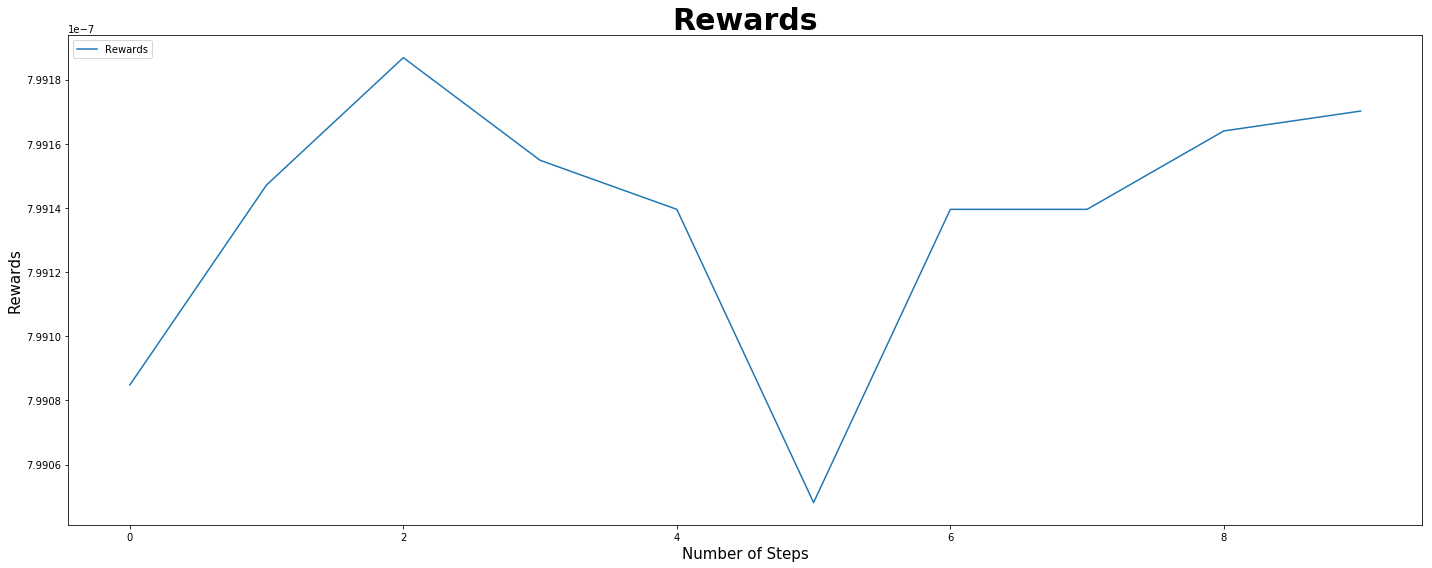



SourceEncoder


,Act_fn,Attn,Norm,Operation,Operation_1,Operation_2,Operation_3,Output,Put,Retrieve_cell,Retrieve_cell_1,Retrieve_cell_2,Retrieve_cell_3,Return_cell
0,LeakyReLU,4.0,7,0.0,3,1,0,False,Emlement_Wise*,7,4,3,4,7
1,Softmax,NaN,4,6.0,2,8,6,False,Inplace,0,9,1,2,7
2,Tanh,0.0,5,7.0,7,0,8,False,Emlement_Wise*,7,4,5,7,8
3,Softmax,4.0,3,NaN,5,5,7,False,Inplace,0,2,4,2,7
4,LeakyReLU,2.0,9,9.0,6,3,6,False,Emlement_Wise*,8,4,1,5,6
5,Softplus,1.0,9,0.0,5,3,0,False,Inplace,8,3,3,0,3
6,None,1.0,4,5.0,7,5,7,False,Emlement_Wise*,6,4,5,1,7
7,Softmax,0.0,4,NaN,8,1,3,True,Inplace,6,6,3,4,8




TargetEncoder


,Act_fn,Attn,Norm,Operation,Operation_1,Operation_2,Operation_3,Output,Put,Retrieve_cell,Retrieve_cell_1,Retrieve_cell_2,Retrieve_cell_3,Return_cell
0,Sigmoid,1,8,2,None,None,9,True,Plus,2,6,5,7,0




ThinkingCell


,Act_fn,Attn,Norm,Operation,Operation_1,Operation_2,Operation_3,Output,Put,Retrieve_cell_1,Retrieve_cell_2,Retrieve_cell_3,Return_cell
0,Sigmoid,4,4,7,7,3,9,True,Plus,1,3,2,1




Decoder


,Act_fn,Attn,Norm,Operation,Operation_1,Operation_2,Operation_3,Out_opt,Output,Put,Retrieve_cell,Retrieve_cell_1,Retrieve_cell_2,Retrieve_cell_3,Return_cell
0,ReLU,3,9,13,13,8,4,2,True,Plus,4,3,2,2,1


Epoch : [1] Lasting Time: [28.4078]
Loss | Controller [-1.0749] | Actor [-1.9698] | Critic [0.8950] | Entropy [0.0000]


In [13]:
Fet.train(2)